In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
print(os.getcwd())

/home/pkorus/Repositories/dl-master-voices/autovc


In [3]:
import yaml

In [4]:
import sys
sys.path.append('../')
sys.path.append('../rtvc')

import torch
import numpy as np
import autovc

import sounddevice
from helpers import plotting, audio

In [4]:
from rtvc.vocoder import inference as vocoder
vocoder.load_model('../rtvc/vocoder/saved_models/pretrained/pretrained.pt')

Building Wave-RNN
Trainable Parameters: 4.481M
Loading model weights at ../rtvc/vocoder/saved_models/pretrained/pretrained.pt


In [6]:
G = autovc.make_autovc()
C = autovc.make_dvector()
W = autovc.make_wavenet()

In [4]:

metadata = pickle.load(open('metadata.pkl', "rb"))

In [ ]:
spect_vc = []

for sbmt_i in metadata:
             
    x_org = sbmt_i[2]
    x_org, len_pad = pad_seq(x_org)
    uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)
    emb_org = torch.from_numpy(sbmt_i[1][np.newaxis, :]).to(device)
    
    for sbmt_j in metadata:
                   
        emb_trg = torch.from_numpy(sbmt_j[1][np.newaxis, :]).to(device)
        
        with torch.no_grad():
            _, x_identic_psnt, _ = G(uttr_org, emb_org, emb_trg)
            
        if len_pad == 0:
            uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
        else:
            uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()
        
        spect_vc.append( ('{}x{}'.format(sbmt_i[0], sbmt_j[0]), uttr_trg) )
        
        
# with open('results.pkl', 'wb') as handle:
#     pickle.dump(spect_vc, handle)          

In [71]:
from parallel_wavegan.models import ParallelWaveGANGenerator, HiFiGANGenerator

In [83]:
vocoder_conf = '../dl-master-voices.git/pretrained_model/vctk_hifigan.v1/config.yml'
with open(vocoder_conf) as f:
    config = yaml.load(f, Loader=yaml.Loader)
    
config

{'allow_cache': True,
 'batch_max_steps': 8400,
 'batch_size': 16,
 'config': 'conf/hifigan.v1.yaml',
 'dev_dumpdir': 'dump/dev_all/norm',
 'dev_feats_scp': None,
 'dev_segments': None,
 'dev_wav_scp': None,
 'discriminator_adv_loss_params': {'average_by_discriminators': False},
 'discriminator_grad_norm': -1,
 'discriminator_optimizer_params': {'betas': [0.5, 0.9],
  'lr': 0.0002,
  'weight_decay': 0.0},
 'discriminator_optimizer_type': 'Adam',
 'discriminator_params': {'follow_official_norm': True,
  'period_discriminator_params': {'bias': True,
   'channels': 32,
   'downsample_scales': [3, 3, 3, 3, 1],
   'in_channels': 1,
   'kernel_sizes': [5, 3],
   'max_downsample_channels': 1024,
   'nonlinear_activation': 'LeakyReLU',
   'nonlinear_activation_params': {'negative_slope': 0.1},
   'out_channels': 1,
   'use_spectral_norm': False,
   'use_weight_norm': True},
  'periods': [2, 3, 5, 7, 11],
  'scale_discriminator_params': {'bias': True,
   'channels': 128,
   'downsample_scales':

In [118]:
# load vocoder config 
vocoder_conf = '../dl-master-voices.git/pretrained_model/vctk_parallel_wavegan.v1/config.yml'
# vocoder_conf = '../dl-master-voices.git/pretrained_model/vctk_hifigan.v1/config.yml'
with open(vocoder_conf) as f:
    config = yaml.load(f, Loader=yaml.Loader)
    
# define pytorch model
vocoder = ParallelWaveGANGenerator(**config["generator_params"])
vocoder = vocoder.to("cuda")

In [114]:
fake_mels = np.random.sample((4, 1500, 80)).astype(np.float32)
fake_mels = torch.Tensor(fake_mels).transpose(2, 1).cuda()
print(fake_mels.shape)

torch.Size([4, 80, 1500])


In [92]:
print(fake_mels.cuda().dtype)

torch.float32


In [115]:
x_identic_psnt[0, 0].T[None, ...].shape

torch.Size([1, 80, 256])

In [120]:
with torch.no_grad():
    y = vocoder(fake_mels, None)

RuntimeError: Given groups=1, weight of size [64, 1, 1], expected input[4, 80, 1500] to have 1 channels, but got 80 channels instead

In [116]:
with torch.no_grad():
    waveform_rec = vocoder(x_identic_psnt[0, 0].T[None, ...])

In [6]:
spect_vc = pickle.load(open('results.pkl', 'rb'))
device = torch.device("cuda")



<All keys matched successfully>

In [ ]:
for spect in spect_vc:
    name = spect[0]
    c = spect[1]
    print(name)
    waveform = wavegen(model, c=c)   
    librosa.output.write_wav(name+'.wav', waveform, sr=16000)

In [ ]:
librosa.output.write_wav(name+'.wav', waveform, sr=16000)

In [ ]:
print(uttr_org.shape)
print(emb_org.shape)
print(emb_trg.shape)

In [182]:
waveform = audio.decode_audio('wavs/p225/p225_003.wav')
# waveform = audio.decode_audio('../dl-master-voices.git/data/vs_mv_seed/male/003.wav')
sounddevice.play(waveform, 16000)

In [143]:
waveform_2 = audio.decode_audio('wavs/p228/p228_005.wav')
sounddevice.play(waveform_2, 16000)

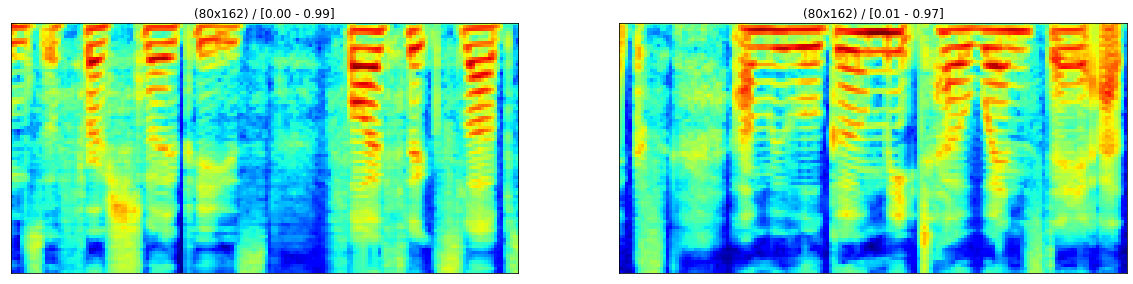

In [144]:
spectrum = autovc.mel_spectrogram(waveform)
spectrum_2 = autovc.mel_spectrogram(waveform_2)

# fig = plotting.get_figure(figsize=(12, 8))
_ = plotting.images((spectrum.T, spectrum_2.T), figwidth=10, cmap='jet')

In [28]:
dir(torch.from_numpy(spectrum))

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__ilshift__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rshift__',
 '__rsub__',
 '__r

In [145]:
emb_1 = C(torch.from_numpy(spectrum[np.newaxis, :, :]).cuda())
emb_2 = C(torch.from_numpy(spectrum_2[np.newaxis, :, :]).cuda())

In [32]:
spectrum.shape

(162, 80)

In [146]:
spectrum_gpu = torch.from_numpy(autovc.pad_seq(spectrum)[0][np.newaxis, :, :]).cuda()

with torch.no_grad():
    _, spectrum_vc, _ = G(spectrum_gpu, emb_1, emb_2)

In [159]:
np.exp(-100 / 20 * np.log(10))

9.99999999999998e-06

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


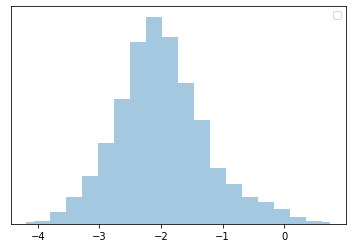

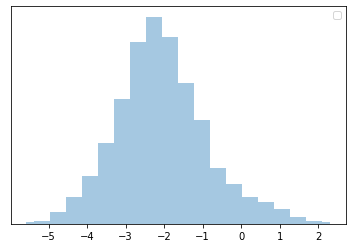

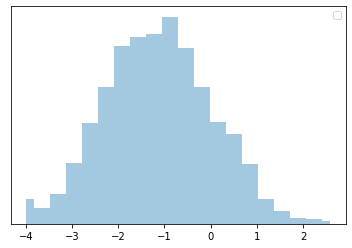

In [205]:
def denormalize(s):
#     return (100 * s - 84) / 20
    return (100 * (s - 1) + 16) / 20

sp = denormalize(spectrum).T
sp2 = 8 * (spectrum.T - 0.7)

_ = plotting.hist((sp).ravel())
_ = plotting.hist((sp2).ravel())
_ = plotting.hist(mel.ravel())

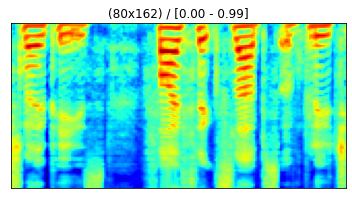

In [100]:
_ = plotting.image(spectrum.T, cmap='jet')

In [286]:
from rtvc.synthesizer import audio as synth_a
from rtvc.synthesizer.hparams import hparams

No handles with labels found to put in legend.


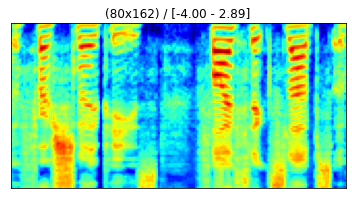

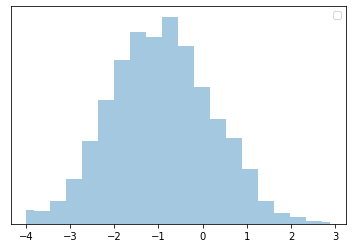

In [296]:
mel = synth_a.melspectrogram(waveform, hparams)
plotting.image(mel, cmap='jet')
plotting.hist(mel.ravel())
waveform_rec = synth_a.inv_mel_spectrogram(mel, hparams)
sounddevice.play(waveform_rec.squeeze(), 16000)

In [89]:
hparams

{'allow_clipping_in_normalization': True,
 'clip_mels_length': True,
 'fmax': 7600,
 'fmin': 55,
 'griffin_lim_iters': 60,
 'hop_size': 200,
 'max_abs_value': 4.0,
 'max_mel_frames': 900,
 'min_level_db': -100,
 'n_fft': 800,
 'num_mels': 80,
 'power': 1.5,
 'preemphasis': 0.97,
 'preemphasize': True,
 'ref_level_db': 20,
 'rescale': True,
 'rescaling_max': 0.9,
 'sample_rate': 16000,
 'signal_normalization': True,
 'silence_min_duration_split': 0.4,
 'speaker_embedding_size': 256,
 'symmetric_mels': True,
 'synthesis_batch_size': 16,
 'trim_silence': True,
 'tts_cleaner_names': ['english_cleaners'],
 'tts_clip_grad_norm': 1.0,
 'tts_decoder_dims': 128,
 'tts_dropout': 0.5,
 'tts_embed_dims': 512,
 'tts_encoder_K': 5,
 'tts_encoder_dims': 256,
 'tts_eval_interval': 500,
 'tts_eval_num_samples': 1,
 'tts_lstm_dims': 1024,
 'tts_num_highways': 4,
 'tts_postnet_K': 5,
 'tts_postnet_dims': 512,
 'tts_schedule': [(2, 0.001, 20000, 12),
                  (2, 0.0005, 40000, 12),
             

tensor([[ 6.3518e-01,  8.1531e-01,  7.9524e-01,  ...,  1.5183e-01,
          1.8421e-01,  2.1069e-01],
        [ 6.3614e-01,  8.0077e-01,  7.6569e-01,  ...,  1.3064e-01,
          1.5780e-01,  1.8529e-01],
        [ 6.3772e-01,  7.8757e-01,  7.6773e-01,  ...,  1.2169e-01,
          1.5621e-01,  1.8837e-01],
        ...,
        [ 1.3678e-03, -1.3660e-03, -1.0047e-03,  ...,  1.0166e-03,
          1.3127e-04,  7.8221e-04],
        [ 2.7260e-04, -1.2053e-03, -1.2289e-03,  ...,  1.2565e-03,
          5.5425e-04,  7.8472e-04],
        [ 1.5476e-03,  1.4976e-04, -7.1564e-04,  ...,  8.0632e-04,
          2.2528e-04,  3.1926e-04]], device='cuda:0')

In [249]:
hparams

{'allow_clipping_in_normalization': True,
 'clip_mels_length': True,
 'fmax': 7600,
 'fmin': 90,
 'griffin_lim_iters': 60,
 'hop_size': 256,
 'max_abs_value': 4.0,
 'max_mel_frames': 900,
 'min_level_db': -100,
 'n_fft': 1024,
 'num_mels': 80,
 'power': 1.5,
 'preemphasis': 0.97,
 'preemphasize': True,
 'ref_level_db': 16,
 'rescale': True,
 'rescaling_max': 0.9,
 'sample_rate': 16000,
 'signal_normalization': True,
 'silence_min_duration_split': 0.4,
 'speaker_embedding_size': 256,
 'symmetric_mels': True,
 'synthesis_batch_size': 16,
 'trim_silence': True,
 'tts_cleaner_names': ['english_cleaners'],
 'tts_clip_grad_norm': 1.0,
 'tts_decoder_dims': 128,
 'tts_dropout': 0.5,
 'tts_embed_dims': 512,
 'tts_encoder_K': 5,
 'tts_encoder_dims': 256,
 'tts_eval_interval': 500,
 'tts_eval_num_samples': 1,
 'tts_lstm_dims': 1024,
 'tts_num_highways': 4,
 'tts_postnet_K': 5,
 'tts_postnet_dims': 512,
 'tts_schedule': [(2, 0.001, 20000, 12),
                  (2, 0.0005, 40000, 12),
            

In [280]:
hparams.hop_size = 256
hparams.win_size = 800
hparams.n_fft = 1024
hparams.ref_level_db = 16
hparams.fmin = 90
hparams.fmax = 7600

In [253]:
synth_a._inv_mel_basis = None

In [247]:
import librosa
librosa.filters.mel(16000, 1024, n_mels=80, fmin=90, fmax=7600).shape

(80, 513)

In [265]:
# _ = plotting.images(, figwidth=20, cmap='jet')
# np.sum(librosa.filters.mel(16000, 1024, n_mels=80, fmin=90, fmax=7600), axis=1)

In [252]:
S = synth_a._mel_to_linear(spectrum.T, hparams)
print(S.shape)

# angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
# S_complex = np.abs(S).astype(np.complex)
# y = synth_a._istft(S_complex * angles, hparams)

# for i in range(60):
#     angles = np.exp(1j * np.angle(synth_a._stft(y, hparams)))
#     y = synth_a._istft(S_complex * angles, hparams)

(401, 162)


In [282]:
from types import SimpleNamespace

hparams = SimpleNamespace(
    hop_size = 256,
    win_size = 800,
    n_fft = 1024,
    ref_level_db = 16,
    fmin = 90,
    fmax = 7600,
)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


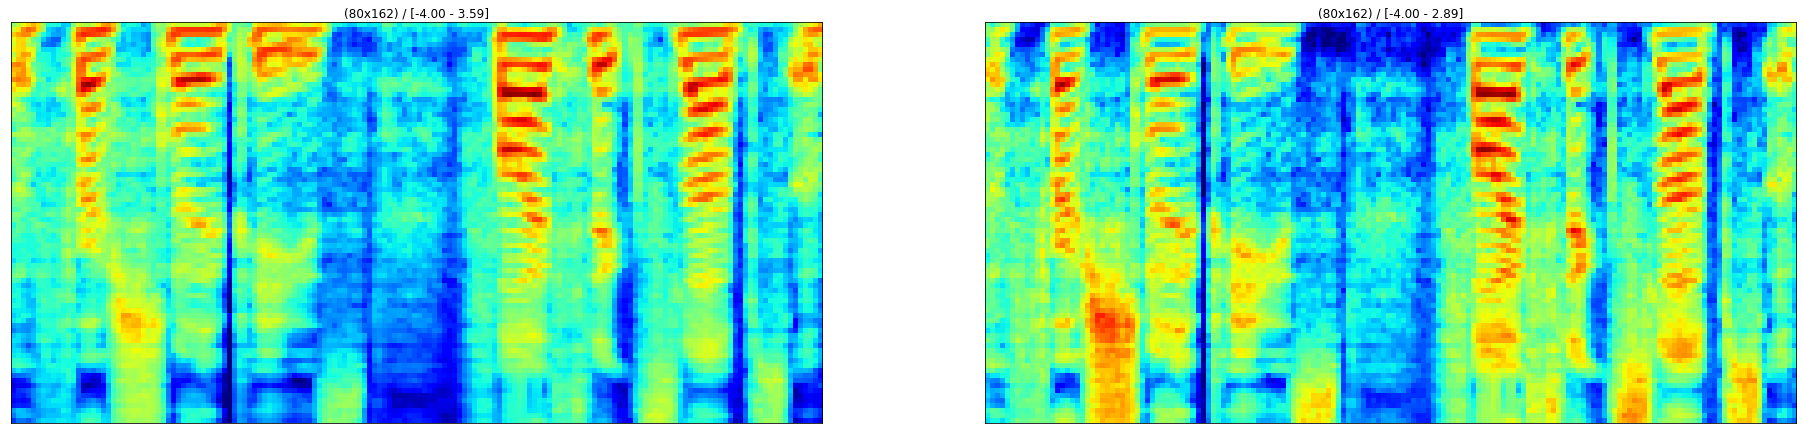

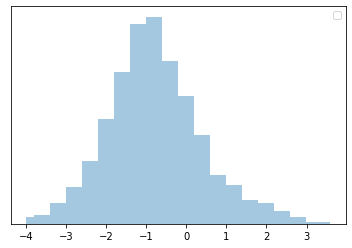

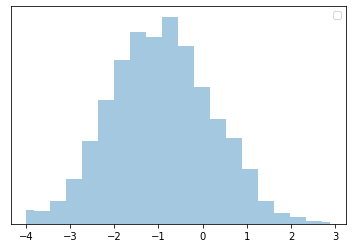

In [330]:
S1 = autovc.mel_spectrogram(waveform)
S2 = synth_a.melspectrogram(waveform, hparams).T
# mel = synth_a.melspectrogram(waveform, hparams)

def renormalize(s, hparams):
#     return (100 * s - 84) / 20
#     return (100 * (s - 1) + 16) / 20
#     return u
    return synth_a._normalize(100 * (s - 1) - 4, hparams)

# sp = spectrum_vc[0, 0, ...].cpu().numpy()
# S1 = spectrum.T
S1 = renormalize(S1, hparams)

plotting.images((S1.T, S2.T), cmap='jet', figwidth=16)
_ = plotting.hist(S1.ravel())
_ = plotting.hist(S2.ravel())

No handles with labels found to put in legend.


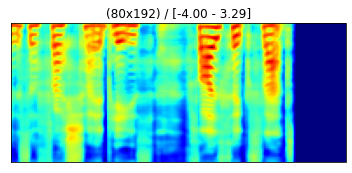

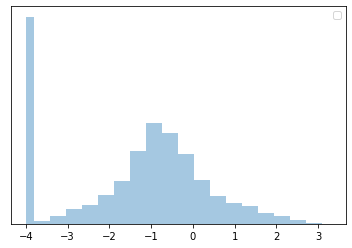

In [392]:
hparams.hop_size = 256
hparams.win_size = 800
hparams.n_fft = 1024
hparams.ref_level_db = 16
hparams.fmin = 90
hparams.fmax = 7600
hparams.griffin_lim_iters = 10

def renormalize(s, hparams):
#     return (100 * s - 84) / 20
#     return (100 * (s - 1) + 16) / 20
#     return u
    return np.clip(synth_a._normalize(100 * (s - 1) - 4, hparams), -4, 4)

spectrum = autovc.mel_spectrogram(waveform)
# spectrum = synth_a.melspectrogram(waveform, hparams).T
# mel = synth_a.melspectrogram(waveform, hparams)

sp = spectrum_vc[0, 0, ...].cpu().numpy().T
# sp = spectrum.T
sp = renormalize(sp, hparams)

plotting.image(sp, cmap='jet')
plotting.hist(sp.ravel())

waveform_rec = synth_a.inv_mel_spectrogram(sp, hparams)
# waveform_rec = vocoder.infer_waveform(sp) # progress_callback=lambda *args: None

sounddevice.play(waveform_rec.squeeze(), 16000)

In [208]:
sp = spectrum_vc[0, 0, ...].cpu().numpy()
sp = spectrum
sp = denormalize(sp).T

waveform_rec = vocoder.infer_waveform(sp) # progress_callback=lambda *args: None
sounddevice.play(waveform_rec.squeeze(), 16000)

{| ████████████████ 38000/38400 | Batch Size: 4 | Gen Rate: 6.9kHz | }

In [153]:
sounddevice.play(waveform_rec.squeeze(), 16000)

In [57]:
print(len(waveform) / 16000)
print(len(waveform_rec) / 16000)

2.58
3.072


In [56]:
waveform_rec = autovc.wavegen(W, c=x_identic_psnt[0, 0].cpu())

100%|██████████| 49152/49152 [05:27<00:00, 150.22it/s]


In [22]:
sounddevice.play(waveform_rec.cpu().numpy().squeeze(), 16000)

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [36]:
waveform_rec = wavegen(wavenet, c=spectrum)

NameError: name 'wavegen' is not defined

In [15]:
torch.from_numpy(spectrum[np.newaxis, :, :]).cuda().shape

torch.Size([1, 251, 80])

In [ ]:
x_identic_psnt[0, 0].cpu().numpy()

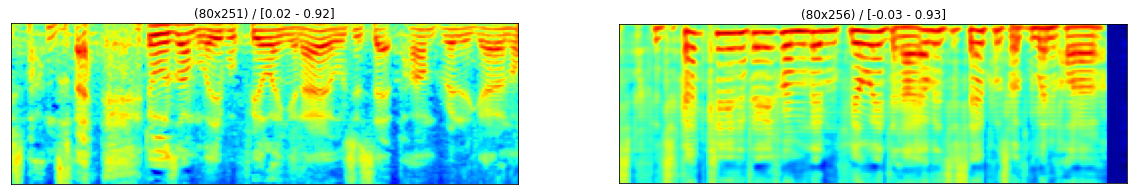

In [11]:
_ = plotting.images((spectrum.T, x_identic_psnt[0, 0].cpu().numpy().T), figwidth=10, cmap='jet')

In [396]:
def get_speakerembedding(target_speaker):
    
    # Target passed as filename
    if isinstance(target_speaker, str):
        target_speaker = audio.decode_audio(target_speaker)    
        target_speaker = autovc.mel_spectrogram(target_speaker)
        emb_tgt = C(torch.from_numpy(target_speaker[np.newaxis, :, :]).cuda())
    
    # Target passed as speaker embedding
    elif target_speaker.ndim == 1 and len(target_speaker) == 256:
        emb_tgt = torch.from_numpy(target_speaker).cuda()
        
    # Target passed as waveform
    elif target_speaker.ndim == 1 and len(target_speaker) > 256:
        target_speaker = autovc.mel_spectrogram(target_speaker)
        emb_tgt = C(torch.from_numpy(target_speaker[np.newaxis, :, :]).cuda())
        
    return emb_tgt


def vc(waveform, target_speaker, vocoder='gl'):
    
    if isinstance(waveform, str):    
        waveform = audio.decode_audio(waveform)
        
    spectrum = autovc.mel_spectrogram(waveform)
    emb_src = C(torch.from_numpy(spectrum[np.newaxis, :, :]).cuda())
    
    emb_tgt = get_speakerembedding(target_speaker)
    
    # Run voice conversion
    spectrum_gpu = torch.from_numpy(autovc.pad_seq(spectrum)[0][np.newaxis, :, :]).cuda()

    with torch.no_grad():
        _, spectrum_vc, _ = G(spectrum_gpu, emb_src, emb_tgt)
        
    hparams.hop_size = 256
    hparams.win_size = 800
    hparams.n_fft = 1024
    hparams.ref_level_db = 16
    hparams.fmin = 90
    hparams.fmax = 7600
    hparams.griffin_lim_iters = 10

    def renormalize(s, hparams):
        return synth_a._normalize(100 * (s - 1) - 4, hparams)
        
    sp = spectrum_vc.cpu().numpy()[0, 0, ...].T
#     sp = renormalize(sp, hparams)

    if vocoder == 'gl':
        sp = renormalize(sp, hparams)
        waveform_rec = synth_a.inv_mel_spectrogram(sp, hparams)
    
    elif vocoder == 'wavernn':
        from rtvc.vocoder import inference as vocoder
        vocoder.load_model('../rtvc/vocoder/saved_models/pretrained/pretrained.pt')
        
        sp = renormalize(sp, hparams)
        waveform_rec = vocoder.infer_waveform(sp) # progress_callback=lambda *args: None
    
    elif vocoder == 'wavenet':
        waveform_rec = autovc.wavegen(W, c=spectrum_vc[0, 0].cpu())
#         waveform_rec = wavegen(wavenet, c=spectrum)
    
    else:
        raise ValueError(f'Invalid vocoder: {vocoder}')
        
    return waveform_rec

## VC via API

In [32]:
sounddevice.play(audio.decode_audio('../data/vs_mv_seed/female/021.wav', target_length=5), 16000)

In [14]:
sounddevice.play(audio.decode_audio('wavs/p225/p225_003.wav', target_length=5), 16000)
# sounddevice.play(audio.decode_audio('wavs/p228/p228_005.wav', target_length=5), 16000)

In [49]:
autovc.reset()
autovc._target_length = 3
# converted = autovc.vc('wavs/p225/p225_003.wav', 'wavs/p228/p228_005.wav', 'gl')
# converted = autovc.vc('../data/vs_mv_seed/female/007.wav', '../data/vs_mv_seed/female/021.wav', 'wavernn')
converted = autovc.vc('../data/vs_mv_seed/female/007.wav', 'wavs/p228/p228_005.wav', 'gl')
sounddevice.play(converted.squeeze(), 16000)

In [46]:
# librosa.output.write_wav('autovc_converted_p225.3_to_p228.5.wav', converted, 16000)
librosa.output.write_wav('autovc_converted_f007_to_f021.wav', converted, 16000)

In [34]:
sounddevice.play(converted.squeeze(), 16000)

## Full Conversion Process

In [96]:
np.concatenate((waveform.squeeze(), target_waveform.squeeze())).shape

(64000,)

In [99]:
vocoder_ = 'wavernn'

waveform = audio.decode_audio('wavs/p225/p225_003.wav', target_length=2)
spectrum = autovc.mel_spectrogram(waveform)
emb_src = C(torch.from_numpy(spectrum[np.newaxis, :, :]).cuda())

target_waveform = audio.decode_audio('wavs/p228/p228_005.wav', target_length=2)
target_speaker = autovc.mel_spectrogram(target_waveform)
emb_tgt = C(torch.from_numpy(target_speaker[np.newaxis, :, :]).cuda())

# Run voice conversion
spectrum_gpu = torch.from_numpy(autovc.pad_seq(spectrum)[0][np.newaxis, :, :]).cuda()

with torch.no_grad():
    _, spectrum_vc, _ = G(spectrum_gpu, emb_src, emb_tgt)
    
sounddevice.play(np.concatenate((waveform.squeeze(), target_waveform.squeeze())), 16000)
# sounddevice.play(target_waveform.squeeze(), 16000)

In [74]:
def renormalize(s, hparams):
    return synth_a._normalize(100 * (s - 1) - 4, hparams)

In [75]:
from rtvc.synthesizer import audio as synth_a
from rtvc.synthesizer.hparams import hparams

In [76]:
hparams.hop_size = 256
hparams.win_size = 800
hparams.n_fft = 1024
hparams.ref_level_db = 16
hparams.fmin = 90
hparams.fmax = 7600
hparams.griffin_lim_iters = 100

In [100]:
if vocoder_ == 'gl':
    sp = spectrum_vc.cpu().numpy()[0, 0, ...].T
    sp = renormalize(sp, hparams)
    waveform_rec = synth_a.inv_mel_spectrogram(sp, hparams)

elif vocoder_ == 'wavernn':
    from rtvc.vocoder import inference as vocoder
    vocoder.load_model('../rtvc/vocoder/saved_models/pretrained/pretrained.pt')

    sp = spectrum_vc.cpu().numpy()[0, 0, ...].T
    sp = renormalize(sp, hparams)
    waveform_rec = vocoder.infer_waveform(sp) # progress_callback=lambda *args: None

elif vocoder_ == 'wavenet':
    waveform_rec = autovc.wavegen(W, c=spectrum_vc[0, 0].cpu())


  2%|▏         | 655/32768 [00:04<03:41, 144.69it/s]

KeyboardInterrupt: 


  2%|▏         | 655/32768 [00:20<03:41, 144.69it/s]

In [71]:
waveform_rec = autovc.wavegen(W, c=spectrum_vc[0, 0].cpu())


  0%|          | 285/98304 [00:01<11:07, 146.94it/s]

KeyboardInterrupt: 

In [81]:
sounddevice.play(waveform_rec.squeeze(), 16000)